# BERTweet with Interweaving Fine-Tuned Approach on Disability and Sexual Orientation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [2]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 96.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 29.2 MB/s eta 0:00:00


In [3]:
!pip install -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 36.7 MB/s eta 0:00:00


In [4]:
!pip3 install -q emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import transformers
from transformers import AutoTokenizer,TFRobertaModel

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Functions and Constants

In [7]:
def to_arrays(df):
  X = df['comment_text'].to_numpy()
  y = df['toxicity_binary'].to_numpy()
  return X, y

In [8]:
MAX_SEQUENCE_LENGTH = 128

In [9]:
def tokenizing_pipeline(X, tokenizer):
  bert_tokenized = tokenizer(list(X),
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')
  bert_inputs = [bert_tokenized.input_ids,
                 bert_tokenized.token_type_ids,
                 bert_tokenized.attention_mask]
  return bert_inputs

def load_data(group):
  df_train = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-train-augmented.csv')
  df_val = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-val-augmented.csv')
  df_test = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-test-augmented.csv')

  return df_train, df_val, df_test

def load_data_as_arr(df_train, df_val, df_test):

  X_train, y_train = to_arrays(df_train)
  X_val, y_val = to_arrays(df_val)
  X_test, y_test = to_arrays(df_test)

  return X_train, y_train, X_test, y_test, X_val, y_val

In [10]:
def build_bertweet_cls_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size=100, 
                          dropout=0.3,
                          learning_rate=0.0001,
                          num_train_layers=0):

    # freeze all pre-trained BERTweet layers
    if num_train_layers == 0:
      bertweet_model.trainable = False

    # partially freeze the first n pre-trained BERTweet layers
    else:
        for layer_num in range(num_train_layers):
            bertweet_model.roberta.encoder.layer[layer_num].trainable = False
    
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    # Use the same bertweet model instance
    bert_out = bertweet_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    f1_score = tfa.metrics.F1Score(1, threshold = 0.5)

    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                                        tf.keras.metrics.Precision(),
                                        tf.keras.metrics.Recall(),
                                        f1_score])

    return classification_model

## Load All Available Data for Disability and Sexual Orientation

In [12]:
# Disability
disability_train_df, disability_val_df, disability_test_df = load_data('disability')
X_disability_train, y_disability_train, X_disability_test, y_disability_test, X_disability_val, y_disability_val = load_data_as_arr(disability_train_df, disability_val_df, disability_test_df)

# Sexual Orientation
sexual_orientation_train_df, sexual_orientation_val_df, sexual_orientation_test_df = load_data('sexual-orientation')
X_sexual_orientation_train, y_sexual_orientation_train, X_sexual_orientation_test, y_sexual_orientation_test, X_sexual_orientation_val, y_sexual_orientation_val = load_data_as_arr(sexual_orientation_train_df, sexual_orientation_val_df, sexual_orientation_test_df)

In [13]:
X_disability_train[1]

' mental disability is extremely physical'

In [14]:
X_disability_train[9]

' There are many different types of disabilities. For example: mental, cognitive, visual, hearing, physical, and speech. Some people physically cannot speak English'

In [15]:
len(X_disability_train)

24904

In [16]:
X_sexual_orientation_train[0]

' have you had a boyfriend before?'

In [17]:
len(X_sexual_orientation_train)

15344

## Load BERTweet Model from_pretrained()

In [18]:
bertweet_tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base",
                                                    use_fast=False,
                                                    normalization=True,
                                                    add_special_tokens=True,
                                                    return_attention_mask=True)
bertweet_model = TFRobertaModel.from_pretrained("vinai/bertweet-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [19]:
bertweet_model.summary()

Model: "tf_roberta_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 134899968 
 )                                                               
                                                                 
Total params: 134,899,968
Trainable params: 134,899,968
Non-trainable params: 0
_________________________________________________________________


## Tokenize Data Splits

In [20]:
# Disability
bertweet_disability_train_inputs = tokenizing_pipeline(X_disability_train, bertweet_tokenizer)
bertweet_disability_test_inputs = tokenizing_pipeline(X_disability_test, bertweet_tokenizer)
bertweet_disability_val_inputs = tokenizing_pipeline(X_disability_val, bertweet_tokenizer)

# Sexual Orientation
bertweet_sexual_orientation_train_inputs = tokenizing_pipeline(X_sexual_orientation_train, bertweet_tokenizer)
bertweet_sexual_orientation_test_inputs = tokenizing_pipeline(X_sexual_orientation_test, bertweet_tokenizer)
bertweet_sexual_orientation_val_inputs = tokenizing_pipeline(X_sexual_orientation_val, bertweet_tokenizer)

# Calculate Class Weights for Each Group

Get class weights for disability train set:

In [21]:
neg, pos = np.bincount(y_disability_train)
total = neg + pos
print('Disability Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

disability_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Disability Weight for class 0: {:.2f}'.format(weight_for_0))
print('Disability Weight for class 1: {:.2f}'.format(weight_for_1))

Disability Examples:
    Total: 24904
    Positive: 13009 (52.24% of total)

Disability Weight for class 0: 1.05
Disability Weight for class 1: 0.96


Get class weights for sexual orientation train set:

In [22]:
neg, pos = np.bincount(y_sexual_orientation_train)
total = neg + pos
print('Sexual Orientation Train Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

sexual_orientation_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Sexual Orientation Train Weight for class 0: {:.2f}'.format(weight_for_0))
print('Sexual Orientation Train Weight for class 1: {:.2f}'.format(weight_for_1))

Sexual Orientation Train Examples:
    Total: 15344
    Positive: 7415 (48.33% of total)

Sexual Orientation Train Weight for class 0: 0.97
Sexual Orientation Train Weight for class 1: 1.03


### Define Hyperparameters for both models

In [23]:
# hyperparameters
batch_size=24
num_train_layers=8
learning_rate=1e-6

# Build Disability Model

In [24]:
disability_model = build_bertweet_cls_model(num_train_layers=num_train_layers, learning_rate=learning_rate)
disability_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                              

# Build Sexual Orientation Model

In [25]:
sexual_orientation_model = build_bertweet_cls_model(num_train_layers=num_train_layers, learning_rate=learning_rate)
sexual_orientation_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                            

# Interweaving Fine-Tuning: Train Disability and Sexual Orientation Models on ther Respective Data

## Round 1: Train Disability Model for 1 epochs

In [26]:
disability_round1_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 99s 79ms/step - loss: 0.5983 - binary_accuracy: 0.6691 - precision: 0.6991 - recall: 0.6436 - f1_score: 0.6702 - val_loss: 0.4674 - val_binary_accuracy: 0.7697 - val_precision: 0.7780 - val_recall: 0.7780 - val_f1_score: 0.7780


## Round 2: Train Sexual Orientation Model for 1 epoch

In [27]:
sexual_orientation_round2_history = sexual_orientation_model.fit(bertweet_sexual_orientation_train_inputs,
                                          y_sexual_orientation_train,
                                          validation_data=(bertweet_sexual_orientation_val_inputs, y_sexual_orientation_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=sexual_orientation_class_weight)

640/640 [==============================] - 69s 84ms/step - loss: 0.5738 - binary_accuracy: 0.7237 - precision_1: 0.7209 - recall_1: 0.6989 - f1_score: 0.7097 - val_loss: 0.4237 - val_binary_accuracy: 0.8097 - val_precision_1: 0.7948 - val_recall_1: 0.8270 - val_f1_score: 0.8106


## Round 3: Train Disability Model for 1 epoch

In [28]:
disability_round3_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.4654 - binary_accuracy: 0.7859 - precision: 0.7951 - recall: 0.7948 - f1_score: 0.7950 - val_loss: 0.4289 - val_binary_accuracy: 0.7987 - val_precision: 0.8099 - val_recall: 0.7993 - val_f1_score: 0.8046


## Round 4: Train Sexual Orientation Model on for 1 epoch

In [29]:
sexual_orientation_round4_history = sexual_orientation_model.fit(bertweet_sexual_orientation_train_inputs,
                                          y_sexual_orientation_train,
                                          validation_data=(bertweet_sexual_orientation_val_inputs, y_sexual_orientation_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=sexual_orientation_class_weight)

640/640 [==============================] - 51s 79ms/step - loss: 0.4190 - binary_accuracy: 0.8190 - precision_1: 0.8079 - recall_1: 0.8206 - f1_score: 0.8142 - val_loss: 0.3477 - val_binary_accuracy: 0.8406 - val_precision_1: 0.8370 - val_recall_1: 0.8397 - val_f1_score: 0.8384


## Round 5: Train Disability Model for 1 epoch

In [30]:
disability_round5_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.4377 - binary_accuracy: 0.8008 - precision: 0.8161 - recall: 0.7986 - f1_score: 0.8073 - val_loss: 0.4141 - val_binary_accuracy: 0.8064 - val_precision: 0.8031 - val_recall: 0.8300 - val_f1_score: 0.8164


## Round 6: Train Sexual Orientation Model for 1 epoch

In [31]:
sexual_orientation_round6_history = sexual_orientation_model.fit(bertweet_sexual_orientation_train_inputs,
                                          y_sexual_orientation_train,
                                          validation_data=(bertweet_sexual_orientation_val_inputs, y_sexual_orientation_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=sexual_orientation_class_weight)

640/640 [==============================] - 51s 79ms/step - loss: 0.3556 - binary_accuracy: 0.8530 - precision_1: 0.8457 - recall_1: 0.8510 - f1_score: 0.8483 - val_loss: 0.3239 - val_binary_accuracy: 0.8581 - val_precision_1: 0.8463 - val_recall_1: 0.8698 - val_f1_score: 0.8579



## Round 7: Train Disability Model for 1 epoch

In [32]:
disability_round7_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.4236 - binary_accuracy: 0.8095 - precision: 0.8250 - recall: 0.8063 - f1_score: 0.8155 - val_loss: 0.4049 - val_binary_accuracy: 0.8165 - val_precision: 0.8408 - val_recall: 0.7970 - val_f1_score: 0.8183


## Round 8: Train Sexual Orientation Model for 1 epoch

In [33]:
sexual_orientation_round8_history = sexual_orientation_model.fit(bertweet_sexual_orientation_train_inputs,
                                          y_sexual_orientation_train,
                                          validation_data=(bertweet_sexual_orientation_val_inputs, y_sexual_orientation_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=sexual_orientation_class_weight)

640/640 [==============================] - 51s 79ms/step - loss: 0.3252 - binary_accuracy: 0.8663 - precision_1: 0.8608 - recall_1: 0.8630 - f1_score: 0.8619 - val_loss: 0.3134 - val_binary_accuracy: 0.8624 - val_precision_1: 0.8536 - val_recall_1: 0.8698 - val_f1_score: 0.8616


## Round 9: Train Disability Model for 1 epoch

In [34]:
disability_round9_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.4070 - binary_accuracy: 0.8184 - precision: 0.8359 - recall: 0.8118 - f1_score: 0.8237 - val_loss: 0.3947 - val_binary_accuracy: 0.8206 - val_precision: 0.8362 - val_recall: 0.8133 - val_f1_score: 0.8246


## Round 10: Train Sexual Orientation Model for 1 epoch

In [35]:
sexual_orientation_round10_history = sexual_orientation_model.fit(bertweet_sexual_orientation_train_inputs,
                                          y_sexual_orientation_train,
                                          validation_data=(bertweet_sexual_orientation_val_inputs, y_sexual_orientation_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=sexual_orientation_class_weight)

640/640 [==============================] - 51s 79ms/step - loss: 0.3091 - binary_accuracy: 0.8716 - precision_1: 0.8655 - recall_1: 0.8695 - f1_score: 0.8675 - val_loss: 0.3057 - val_binary_accuracy: 0.8679 - val_precision_1: 0.8585 - val_recall_1: 0.8762 - val_f1_score: 0.8672


## Round 11: Train Disability Model for 1 epoch

In [36]:
disability_round11_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.3972 - binary_accuracy: 0.8231 - precision: 0.8402 - recall: 0.8166 - f1_score: 0.8282 - val_loss: 0.3921 - val_binary_accuracy: 0.8247 - val_precision: 0.8519 - val_recall: 0.8012 - val_f1_score: 0.8258


## Round 12: Train Sexual Orientation Model for 1 epoch

In [37]:
sexual_orientation_round12_history = sexual_orientation_model.fit(bertweet_sexual_orientation_train_inputs,
                                          y_sexual_orientation_train,
                                          validation_data=(bertweet_sexual_orientation_val_inputs, y_sexual_orientation_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=sexual_orientation_class_weight)

640/640 [==============================] - 51s 79ms/step - loss: 0.2937 - binary_accuracy: 0.8799 - precision_1: 0.8765 - recall_1: 0.8747 - f1_score: 0.8756 - val_loss: 0.2981 - val_binary_accuracy: 0.8718 - val_precision_1: 0.8652 - val_recall_1: 0.8762 - val_f1_score: 0.8707


## Checkpoint #1: Save Model Weights for Rounds 11 and 12

In [38]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Sexual_Orientation_Interwoven_disability-checkpt1-rounds_11_12.hdf5')
sexual_orientation_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Sexual_Orientation_Interwoven_sexual_orientation-checkpt1-rounds_11_12.hdf5')

## Round 13: Train Disability Model for 1 epoch

In [39]:
disability_round13_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.3871 - binary_accuracy: 0.8270 - precision: 0.8454 - recall: 0.8186 - f1_score: 0.8318 - val_loss: 0.3853 - val_binary_accuracy: 0.8268 - val_precision: 0.8385 - val_recall: 0.8249 - val_f1_score: 0.8317


## Round 14: Train Sexual Orientation Model on for 1 epoch

In [40]:
sexual_orientation_round14_history = sexual_orientation_model.fit(bertweet_sexual_orientation_train_inputs,
                                          y_sexual_orientation_train,
                                          validation_data=(bertweet_sexual_orientation_val_inputs, y_sexual_orientation_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=sexual_orientation_class_weight)

640/640 [==============================] - 51s 79ms/step - loss: 0.2840 - binary_accuracy: 0.8825 - precision_1: 0.8773 - recall_1: 0.8800 - f1_score: 0.8786 - val_loss: 0.2933 - val_binary_accuracy: 0.8765 - val_precision_1: 0.8782 - val_recall_1: 0.8698 - val_f1_score: 0.8740


## Checkpoint #2: Save Model Weights for Rounds 13 and 14

In [41]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Sexual_Orientation_Interwoven_disability-checkpt2-rounds_13_14.hdf5')
sexual_orientation_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Sexual_Orientation_Interwoven_sexual_orientation-checkpt2-rounds_13_14.hdf5')

## Round 15: Train Disability Model for 1 epoch

In [42]:
disability_round15_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.3802 - binary_accuracy: 0.8310 - precision: 0.8513 - recall: 0.8195 - f1_score: 0.8351 - val_loss: 0.3859 - val_binary_accuracy: 0.8307 - val_precision: 0.8625 - val_recall: 0.8012 - val_f1_score: 0.8307


## Round 16: Train Sexual Orientation Model on for 1 epoch

In [43]:
sexual_orientation_round16_history = sexual_orientation_model.fit(bertweet_sexual_orientation_train_inputs,
                                          y_sexual_orientation_train,
                                          validation_data=(bertweet_sexual_orientation_val_inputs, y_sexual_orientation_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=sexual_orientation_class_weight)

640/640 [==============================] - 51s 79ms/step - loss: 0.2733 - binary_accuracy: 0.8879 - precision_1: 0.8813 - recall_1: 0.8875 - f1_score: 0.8844 - val_loss: 0.2894 - val_binary_accuracy: 0.8750 - val_precision_1: 0.8632 - val_recall_1: 0.8865 - val_f1_score: 0.8747


## Checkpoint #3: Save Model Weights for Rounds 15 and 16

In [44]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Sexual_Orientation_Interwoven_disability-checkpt3-rounds_15_16.hdf5')
sexual_orientation_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Sexual_Orientation_Interwoven_sexual_orientation-checkpt3-rounds_15_16.hdf5')

## Round 17: Train Disability Model for 1 epoch

In [45]:
disability_round17_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.3728 - binary_accuracy: 0.8384 - precision: 0.8559 - recall: 0.8304 - f1_score: 0.8430 - val_loss: 0.3833 - val_binary_accuracy: 0.8292 - val_precision: 0.8699 - val_recall: 0.7887 - val_f1_score: 0.8273


## Round 18: Train Sexual Orientation Model for 1 epoch

In [46]:
sexual_orientation_round18_history = sexual_orientation_model.fit(bertweet_sexual_orientation_train_inputs,
                                          y_sexual_orientation_train,
                                          validation_data=(bertweet_sexual_orientation_val_inputs, y_sexual_orientation_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=sexual_orientation_class_weight)

640/640 [==============================] - 51s 79ms/step - loss: 0.2639 - binary_accuracy: 0.8930 - precision_1: 0.8870 - recall_1: 0.8922 - f1_score: 0.8896 - val_loss: 0.2852 - val_binary_accuracy: 0.8804 - val_precision_1: 0.8847 - val_recall_1: 0.8706 - val_f1_score: 0.8776


# Plots for Disability Model

In [47]:
disability_train_f1_scores = [disability_round1_history.history['f1_score'][0][0], 
                     disability_round3_history.history['f1_score'][0][0],
                     disability_round5_history.history['f1_score'][0][0],
                     disability_round7_history.history['f1_score'][0][0],
                     disability_round9_history.history['f1_score'][0][0],
                     disability_round11_history.history['f1_score'][0][0],
                     disability_round13_history.history['f1_score'][0][0],
                     disability_round15_history.history['f1_score'][0][0],
                     disability_round17_history.history['f1_score'][0][0]]
disability_val_f1_scores = [disability_round1_history.history['val_f1_score'][0][0],
                     disability_round3_history.history['val_f1_score'][0][0],
                     disability_round5_history.history['val_f1_score'][0][0],
                     disability_round7_history.history['val_f1_score'][0][0],
                     disability_round9_history.history['val_f1_score'][0][0],
                     disability_round11_history.history['val_f1_score'][0][0],
                     disability_round13_history.history['val_f1_score'][0][0],
                     disability_round15_history.history['val_f1_score'][0][0],
                     disability_round17_history.history['val_f1_score'][0][0]]
disability_train_loss = [disability_round1_history.history['loss'][0],
                     disability_round3_history.history['loss'][0],
                     disability_round5_history.history['loss'][0],
                     disability_round7_history.history['loss'][0],
                     disability_round9_history.history['loss'][0],
                     disability_round11_history.history['loss'][0],
                     disability_round13_history.history['loss'][0],
                     disability_round15_history.history['loss'][0],
                     disability_round17_history.history['loss'][0]]
disability_val_loss = [disability_round1_history.history['val_loss'][0],
                     disability_round3_history.history['val_loss'][0],
                     disability_round5_history.history['val_loss'][0],
                     disability_round7_history.history['val_loss'][0],
                     disability_round9_history.history['val_loss'][0],
                     disability_round11_history.history['val_loss'][0],
                     disability_round13_history.history['val_loss'][0],
                     disability_round15_history.history['val_loss'][0],
                     disability_round17_history.history['val_loss'][0]]
disability_train_binary_accuracy = [disability_round1_history.history['binary_accuracy'][0],
                     disability_round3_history.history['binary_accuracy'][0],
                     disability_round5_history.history['binary_accuracy'][0],
                     disability_round7_history.history['binary_accuracy'][0],
                     disability_round9_history.history['binary_accuracy'][0],
                     disability_round11_history.history['binary_accuracy'][0],
                     disability_round13_history.history['binary_accuracy'][0],
                     disability_round15_history.history['binary_accuracy'][0],
                     disability_round17_history.history['binary_accuracy'][0]]
disability_val_binary_accuracy = [disability_round1_history.history['val_binary_accuracy'][0],
                     disability_round3_history.history['val_binary_accuracy'][0],
                     disability_round5_history.history['val_binary_accuracy'][0],
                     disability_round7_history.history['val_binary_accuracy'][0],
                     disability_round9_history.history['val_binary_accuracy'][0],
                     disability_round11_history.history['val_binary_accuracy'][0],
                     disability_round13_history.history['val_binary_accuracy'][0],
                     disability_round15_history.history['val_binary_accuracy'][0],
                     disability_round17_history.history['val_binary_accuracy'][0]]

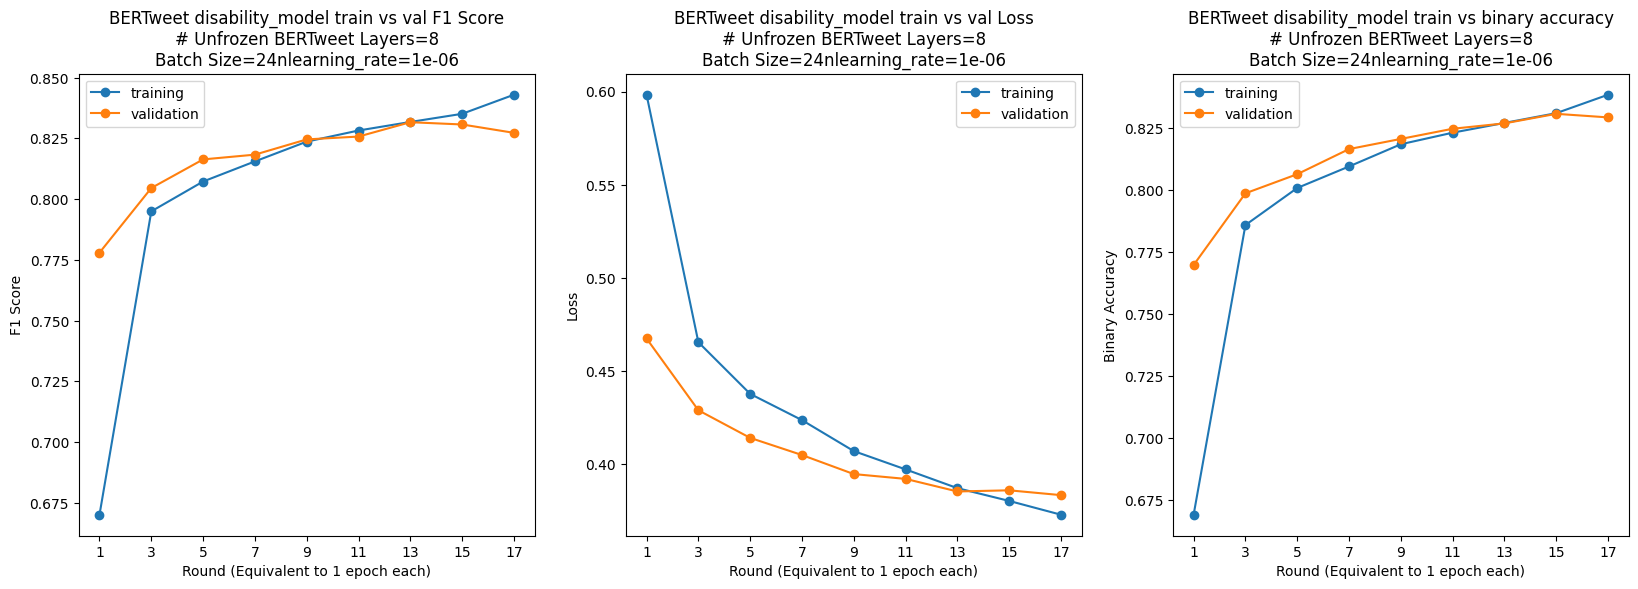

In [48]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20,6))

# F1 Score
axis[0].plot(disability_train_f1_scores, label="training", marker='o')
axis[0].plot(disability_val_f1_scores, label="validation", marker='o')
axis[0].legend()
axis[0].set_ylabel('F1 Score')
axis[0].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[0].set_title('BERTweet disability_model train vs val F1 Score\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Loss
axis[1].plot(disability_train_loss, label="training", marker='o')
axis[1].plot(disability_val_loss, label="validation", marker='o')
axis[1].legend()
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[1].set_title('BERTweet disability_model train vs val Loss\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Binary Accuracy
axis[2].plot(disability_train_binary_accuracy, label="training", marker='o')
axis[2].plot(disability_val_binary_accuracy, label="validation", marker='o')
axis[2].legend()
axis[2].set_ylabel('Binary Accuracy')
axis[2].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[2].set_title('BERTweet disability_model train vs binary accuracy\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))
  
# Combine all the operations and display
plt.show()

# Plots for Sexual Orientation Model

In [49]:
sexual_orientation_train_f1_scores = [sexual_orientation_round2_history.history['f1_score'][0][0],
                     sexual_orientation_round4_history.history['f1_score'][0][0],
                     sexual_orientation_round6_history.history['f1_score'][0][0],
                     sexual_orientation_round8_history.history['f1_score'][0][0],
                     sexual_orientation_round10_history.history['f1_score'][0][0],
                     sexual_orientation_round12_history.history['f1_score'][0][0],
                     sexual_orientation_round14_history.history['f1_score'][0][0],
                     sexual_orientation_round16_history.history['f1_score'][0][0],
                     sexual_orientation_round18_history.history['f1_score'][0][0]]
sexual_orientation_val_f1_scores = [sexual_orientation_round2_history.history['val_f1_score'][0][0],
                     sexual_orientation_round4_history.history['val_f1_score'][0][0],
                     sexual_orientation_round6_history.history['val_f1_score'][0][0],
                     sexual_orientation_round8_history.history['val_f1_score'][0][0],
                     sexual_orientation_round10_history.history['val_f1_score'][0][0],
                     sexual_orientation_round12_history.history['val_f1_score'][0][0],
                     sexual_orientation_round14_history.history['val_f1_score'][0][0],
                     sexual_orientation_round16_history.history['val_f1_score'][0][0],
                     sexual_orientation_round18_history.history['val_f1_score'][0][0]]
sexual_orientation_train_loss = [sexual_orientation_round2_history.history['loss'][0],
                     sexual_orientation_round4_history.history['loss'][0],
                     sexual_orientation_round6_history.history['loss'][0],
                     sexual_orientation_round8_history.history['loss'][0],
                     sexual_orientation_round10_history.history['loss'][0],
                     sexual_orientation_round12_history.history['loss'][0],
                     sexual_orientation_round14_history.history['loss'][0],
                     sexual_orientation_round16_history.history['loss'][0],
                     sexual_orientation_round18_history.history['loss'][0]]
sexual_orientation_val_loss = [sexual_orientation_round2_history.history['val_loss'][0],
                     sexual_orientation_round4_history.history['val_loss'][0],
                     sexual_orientation_round6_history.history['val_loss'][0],
                     sexual_orientation_round8_history.history['val_loss'][0],
                     sexual_orientation_round10_history.history['val_loss'][0],
                     sexual_orientation_round12_history.history['val_loss'][0],
                     sexual_orientation_round14_history.history['val_loss'][0],
                     sexual_orientation_round16_history.history['val_loss'][0],
                     sexual_orientation_round18_history.history['val_loss'][0]]
sexual_orientation_train_binary_accuracy = [sexual_orientation_round2_history.history['binary_accuracy'][0],
                     sexual_orientation_round4_history.history['binary_accuracy'][0],
                     sexual_orientation_round6_history.history['binary_accuracy'][0],
                     sexual_orientation_round8_history.history['binary_accuracy'][0],
                     sexual_orientation_round10_history.history['binary_accuracy'][0],
                     sexual_orientation_round12_history.history['binary_accuracy'][0],
                     sexual_orientation_round14_history.history['binary_accuracy'][0],
                     sexual_orientation_round16_history.history['binary_accuracy'][0],
                     sexual_orientation_round18_history.history['binary_accuracy'][0]]
sexual_orientation_val_binary_accuracy = [sexual_orientation_round2_history.history['val_binary_accuracy'][0],
                     sexual_orientation_round4_history.history['val_binary_accuracy'][0],
                     sexual_orientation_round6_history.history['val_binary_accuracy'][0],
                     sexual_orientation_round8_history.history['val_binary_accuracy'][0],
                     sexual_orientation_round10_history.history['val_binary_accuracy'][0],
                     sexual_orientation_round12_history.history['val_binary_accuracy'][0],
                     sexual_orientation_round14_history.history['val_binary_accuracy'][0],
                     sexual_orientation_round16_history.history['val_binary_accuracy'][0],
                     sexual_orientation_round18_history.history['val_binary_accuracy'][0]]


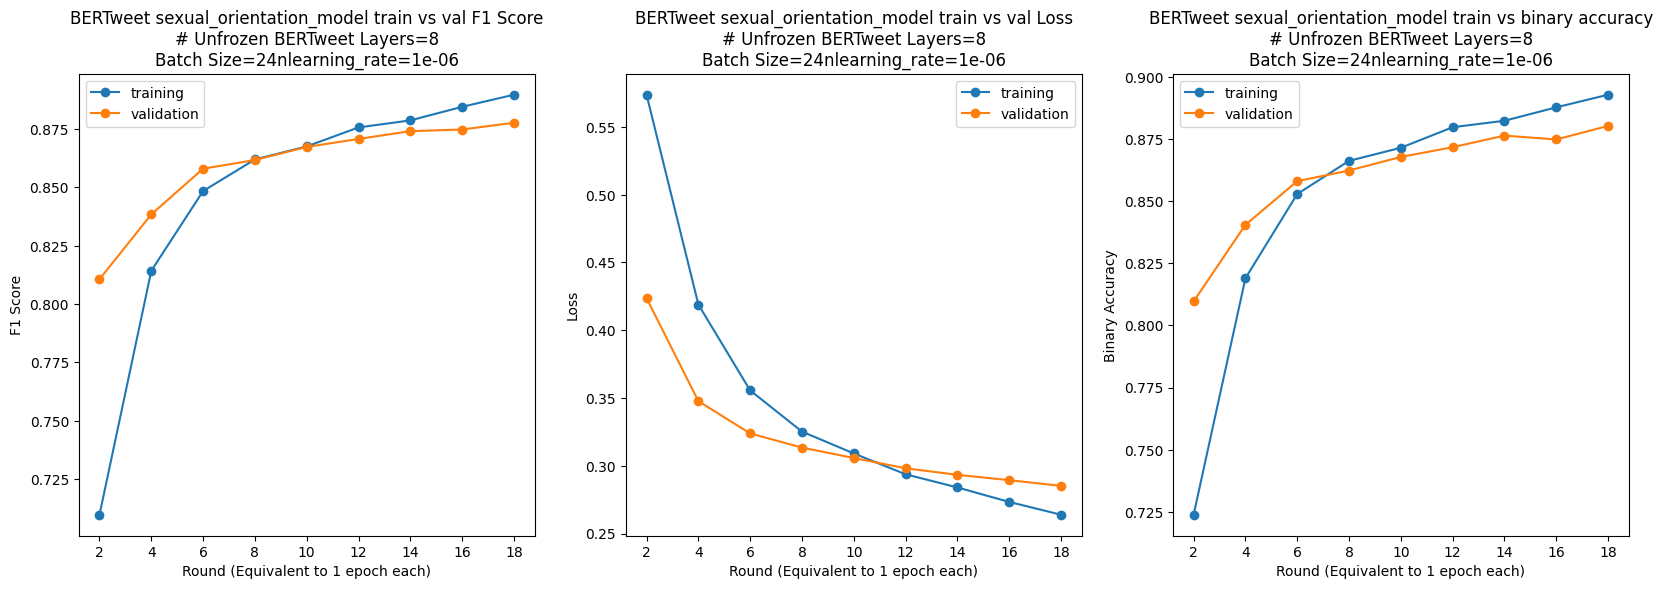

In [50]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20,6))

# F1 Score
axis[0].plot(sexual_orientation_train_f1_scores, label="training", marker='o')
axis[0].plot(sexual_orientation_val_f1_scores, label="validation", marker='o')
axis[0].legend()
axis[0].set_ylabel('F1 Score')
axis[0].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[0].set_title('BERTweet sexual_orientation_model train vs val F1 Score\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Loss
axis[1].plot(sexual_orientation_train_loss, label="training", marker='o')
axis[1].plot(sexual_orientation_val_loss, label="validation", marker='o')
axis[1].legend()
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[1].set_title('BERTweet sexual_orientation_model train vs val Loss\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Binary Accuracy
axis[2].plot(sexual_orientation_train_binary_accuracy, label="training", marker='o')
axis[2].plot(sexual_orientation_val_binary_accuracy, label="validation", marker='o')
axis[2].legend()
axis[2].set_ylabel('Binary Accuracy')
axis[2].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[2].set_title('BERTweet sexual_orientation_model train vs binary accuracy\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))
  
# Combine all the operations and display
plt.show()

# Save Final Model Weights if Needed

In [ ]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Sexual_Orientation_Interwoven_disability.hdf5')
sexual_orientation_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Sexual_Orientation_Interwoven_sexual_orientation.hdf5')

# Keep Previous Results Below/Determine Where to Stop Training
Looking at the train/val curves below, for disability_model we'll keep the weights from checkpoint #2 at round 13, for gender_model we'll keep the weights from checkpoint #1 at round 12.

DISABILITY MODEL RESULTS FOR LAST EPOCH

In [51]:
print('disability_train_f1_scores:', disability_train_f1_scores)
print('disability_val_f1_scores:', disability_val_f1_scores)
print('\ndisability_train_loss:', disability_train_loss)
print('disability_val_loss:', disability_val_loss)
print('\ndisability_train_binary_accuracy:', disability_train_binary_accuracy)
print('disability_val_binary_accuracy:', disability_val_binary_accuracy)

disability_train_f1_scores: [0.6701889, 0.79498714, 0.80725753, 0.8155347, 0.82366246, 0.82823956, 0.8317582, 0.8351089, 0.8429636]
disability_val_f1_scores: [0.7779842, 0.8045816, 0.8163545, 0.8183119, 0.82458204, 0.8257539, 0.8316554, 0.8307248, 0.82728374]

disability_train_loss: [0.5982747673988342, 0.46543872356414795, 0.4376908838748932, 0.4236130714416504, 0.4069945812225342, 0.39716461300849915, 0.387096643447876, 0.38024020195007324, 0.3728344440460205]
disability_val_loss: [0.4674306809902191, 0.4289056658744812, 0.41407787799835205, 0.40487992763519287, 0.39465075731277466, 0.39206865429878235, 0.38531485199928284, 0.3859361708164215, 0.38334915041923523]

disability_train_binary_accuracy: [0.6691294312477112, 0.7858576774597168, 0.8007950782775879, 0.8094683289527893, 0.8184227347373962, 0.8230806589126587, 0.82701575756073, 0.8309508562088013, 0.8383793830871582]
disability_val_binary_accuracy: [0.7697495222091675, 0.7986512780189514, 0.8063583970069885, 0.8164739608764648

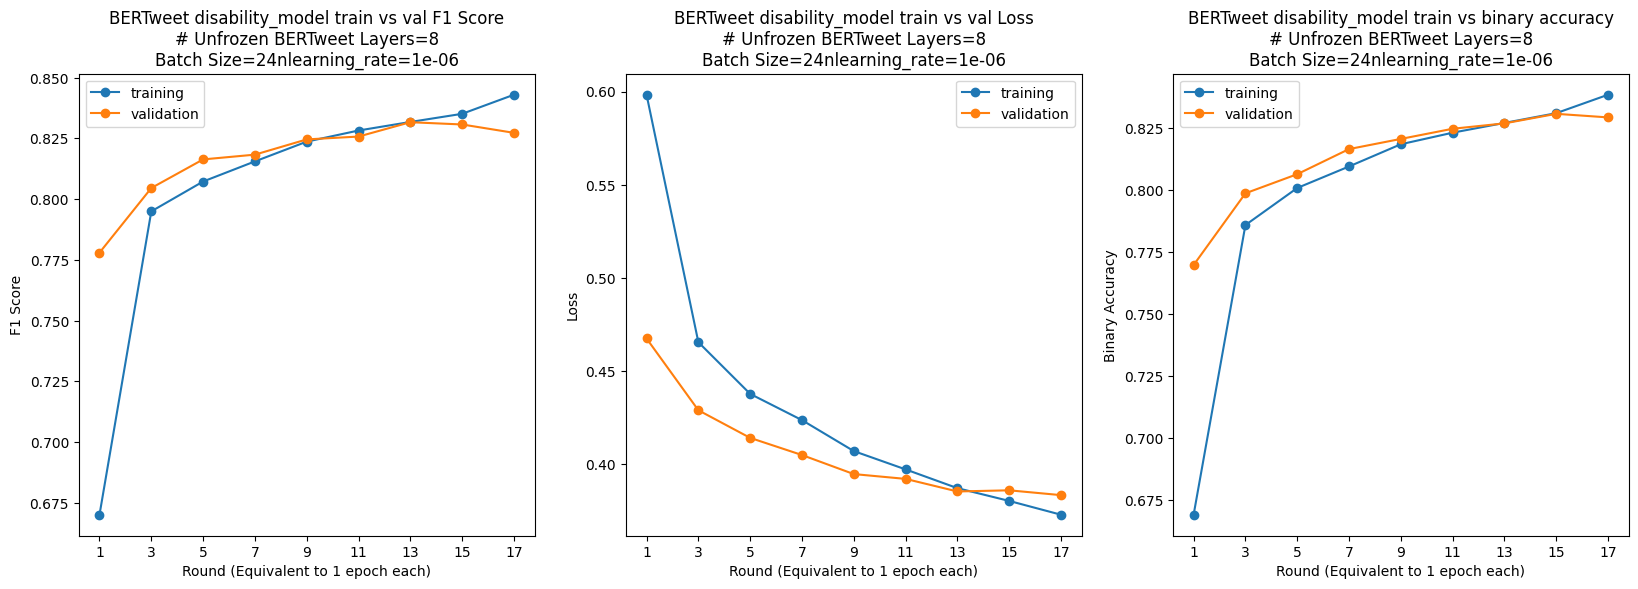

In [ ]:
# DISABILITY MODEL PLOTS - DON'T RUN THIS CELL
# From below, keep disability weights at checkpoint #2 round 13

SEXUAL ORIENTATION MODEL RESULTS FOR LAST EPOCH

In [52]:
print('sexual_orientation_train_f1_scores:', sexual_orientation_train_f1_scores)
print('sexual_orientation_val_f1_scores:', sexual_orientation_val_f1_scores)
print('\nsexual_orientation_train_loss:', sexual_orientation_train_loss)
print('sexual_orientation_val_loss:', sexual_orientation_val_loss)
print('\nsexual_orientation_train_binary_accuracy:', sexual_orientation_train_binary_accuracy)
print('sexual_orientation_val_binary_accuracy:', sexual_orientation_val_binary_accuracy)

sexual_orientation_train_f1_scores: [0.7097172, 0.8142102, 0.8483463, 0.86187625, 0.86746496, 0.87559897, 0.8786104, 0.88442403, 0.889606]
sexual_orientation_val_f1_scores: [0.8105795, 0.83835185, 0.85792565, 0.8616352, 0.8672428, 0.87066245, 0.87400323, 0.8747064, 0.8776]

sexual_orientation_train_loss: [0.5738071799278259, 0.418972909450531, 0.3555739223957062, 0.32521069049835205, 0.30908992886543274, 0.29371559619903564, 0.28399065136909485, 0.2733073830604553, 0.2638653516769409]
sexual_orientation_val_loss: [0.4236955940723419, 0.3476738929748535, 0.32386514544487, 0.3134090304374695, 0.30573219060897827, 0.2981449067592621, 0.293316513299942, 0.2893672585487366, 0.28516489267349243]

sexual_orientation_train_binary_accuracy: [0.7237356901168823, 0.819017231464386, 0.8529718518257141, 0.8663321137428284, 0.8716110587120056, 0.8798878788948059, 0.8824948072433472, 0.8879040479660034, 0.8929874897003174]
sexual_orientation_val_binary_accuracy: [0.809691309928894, 0.8405627012252808

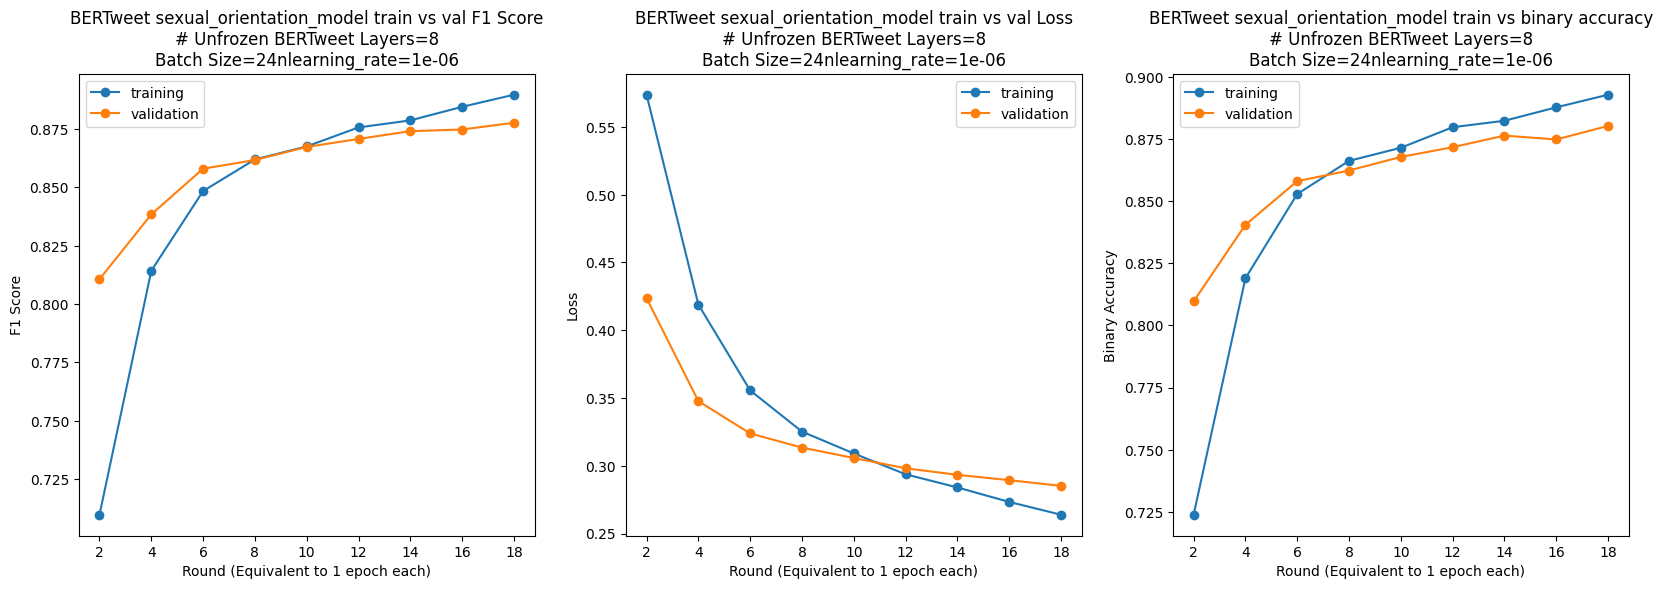

In [ ]:
# SEXUAL ORIENTATION MODEL PLOTS - DON'T RUN THIS CELL
# From below, keep disability weights at checkpoint #1 round 12 b/c that's what we have already saved, limited storage on google drive